In [4]:
import numpy as np
import pandas as pd
import os, os.path
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import random
import time
import copy
import scipy
import seaborn as sns
import datetime
pd.options.display.max_columns=85

In [5]:
rootFolder = '/home/luuk/Documents/VU/AssetPricing/TrackPerformance/' 

TG_StartDate = datetime.date(2020,7,24) # Trading Game start date, will ofcourse be updated 

start = TG_StartDate + datetime.timedelta(days=0)
end   = TG_StartDate + datetime.timedelta(days=7*5)

prices = pd.read_excel(rootFolder+'Prices/IndexedPrices.xlsx', index_col=0) 
tickers = prices.columns

In [9]:
def ReadStockWeights(Group, Week):
    try:
        StockWeights = pd.read_excel(rootFolder+'TG_ExcelFiles/Week' + str(Week)+ '/Game_Group_' + str(Group) + '.xlsx')
        StockWeights.set_index('CODE', inplace=True, drop=True)
        StockWeights = StockWeights.loc[tickers]
        StockWeights.replace(np.NaN, 0, inplace=True)
        
        print('Group: ' +str(Group)+ ' - stock weights from week: ' + str(Week))
        
        # If you submitted an updated .xlsx file this week, it will use this week's stock allocation weights
        return StockWeights[['week '+str(Week)]].copy() 
        
    except:
        print('No updated stock weights for group: ' +str(Group)+ ' - in week: ' + str(Week))
        if Week > 1:
            for i in np.arange(1,Week):
                try:
                    StockWeights = pd.read_excel(rootFolder+'TG_ExcelFiles/Week' + str(Week-i)+ '/Game_Group_' + str(Group) + '.xlsx')
                    StockWeights.set_index('CODE', inplace=True, drop=True)
                    StockWeights = StockWeights.loc[tickers]
                    StockWeights.replace(np.NaN, 0, inplace=True)

                    print('Use stock weights from week: ' + str(Week-i))

                    # If you didn't submit an .xlsx file this week, it will reuse your most recently submitted weights
                    return StockWeights[['week '+str(Week-i)]].copy() 
                     
                except:
                    print('No stock weights found for group: ' +str(Group) +' - in week: ' + str(Week-i))
                                    
        StockWeights = pd.read_excel(rootFolder+'TG_ExcelFiles/DefaultWeights.xlsx')
        StockWeights.set_index('CODE', inplace=True, drop=True)
        StockWeights = StockWeights.loc[tickers]
        StockWeights.replace(np.NaN, 0, inplace=True)

        print('default weights')

        # If you did not submit an .xlsx file in the first week / none ever, it will use the default weights 
        return StockWeights[['week 1']].copy()
        
    
def ValidateStockWeights(SW):
    
    # All negative stock weights are set to 0 (short-sell constraint)
    SW[SW < 0] = 0
    
    # Sum of all stock weights
    SW_total = SW.values.sum() 
    
    
    if SW_total < 0.85 or SW_total > 1:
        
        # If the sum of the stock weights doesn't fall within the 85% and 100% interval, the default weights will be used
        print('Summed stock weights not within 0.85 - 1.0 range --> using default weights')
        
        StockWeights = pd.read_excel(rootFolder+'TG_ExcelFiles/DefaultWeights.xlsx')

        StockWeights.set_index('CODE', inplace=True, drop=True)
        StockWeights = StockWeights.loc[tickers]
        StockWeights.replace(np.NaN, 0, inplace=True)
        
        SW_def = StockWeights[['week 1']].copy()
        SW_total_def = SW_def.values.sum()
        
        return SW_def, SW_total_def
    
    else:
        return SW, SW_total
    
def CalcPtfValue(PortfolioValue, Prices, Group, Week): # <-- 'Week' variable
       
    # Reading out the prices data for the appropriate 'Week' 
    start_date = TG_StartDate + datetime.timedelta(days=7*(Week-1))
    end_date   = TG_StartDate + datetime.timedelta(days=7*(Week))
    
    # The daily prices and daily returns for the appropriate 'Week' 
    WeekPrices   = Prices.loc[start_date:end_date]
    WeekReturns  = np.log(WeekPrices) - np.log(WeekPrices.shift())
    
    # Calculating the cumulative product of the daily returns per stock for the appropriate 'Week' 
    WeekReturnsCP = (WeekReturns + 1).cumprod()
    
    # Reading the Stock Weights from the .xlsx files
    StockWeights  = ReadStockWeights(Group, Week)
    
    # Validating whether the Stock Weights adhere the rules as specified in the Trading Game Manual
    SW, SW_T      = ValidateStockWeights(StockWeights)
    
    # Calculating the invested value in each of the stocks at the start of the 'Week'
    StockAllocation  = SW * PortfolioValue.loc[start_date, Group]
    # Calculating the portfolio value held in cash (if applicable)
    HeldInCash       = (1-SW_T) * PortfolioValue.loc[start_date, Group]
    
    # Invested Value multiplied by daily cumulative returns
    InvestmentValues = WeekReturnsCP * StockAllocation.T.values
    
    # Updating the Portfolio Value dataframe with the daily returns 
    for date in InvestmentValues.index:
        if date != start_date:
            PortfolioValue.loc[date, Group] = InvestmentValues.sum(axis=1)[date] + HeldInCash
    
    print('')
    return PortfolioValue.astype('float')

In [10]:
prices.loc[start:end]

,BT.A-GB,CCL-GB,MKS-GB,BARC-GB,ITRK-GB,BRBY-GB,NXT-GB,UDG-GB,KGF-GB,ITV-GB,EN-FR,AIR-FR,VIE-FR,ADS-DE,G-IT,OR-FR,GL9-IE,CDI-FR,MC-FR,AM-FR,ISP-IT,EDP-PT,BEAN-CH,HO-FR,CAP-FR,CARL.B-DK,COFB-BE,CRG-IE,ING-FR,MAERSK.B-DK,DNB-NO,FI.N-CH,FRE-DE,UTDI-DE,FPE3-DE,PUB-FR,EO-FR,HUH1V-FI,KESKOB-FI,KRX-IE,KBC-BE,GN-DK,...,LIFCO.B-SE,WALL.B-SE,SRCG-CH,AUTO-GB,EQT-SE,G24-DE,UBSG-CH,PST-IT,ATC-NL,1COV-DE,AMUN-FR,VACN-CH,ORSTED-DK,UN01-DE,TMV-DE,CTEC-GB,FTI-FR,GALE-CH,MNG-GB,VIFN-CH,ESSITY.B-SE,DHER-DE,BG-AT,SHL-DE,BESI-NL,LIN-DE,AVST-GB,URW-NL,NETC-DK,ADYEN-NL,KOJAMO-FI,SIGN-CH,NDA.SE-SE,KBX-DE,ALC-CH,PHNX-GB,ADE-NO,NEXI-IT,TRN-GB,BCVN-CH,PRX-NL,FDJ-FR
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-07-24,50.652430,26.445085,42.029200,77.906950,115.14134,76.155883,131.02010,122.20346,124.57567,51.567660,105.30325,77.215030,117.49773,132.82814,102.177480,145.76648,66.464500,122.14949,158.21964,65.743834,102.907810,166.00595,193.92658,66.971830,123.64672,142.51202,117.02831,149.66073,283.67790,123.23077,102.95029,124.12262,106.790960,104.90026,111.84946,61.965060,109.05203,153.97283,162.17120,171.12467,96.344364,158.33246,...,211.34953,131.39087,117.16768,116.52006,238.40997,189.54363,105.65226,128.68305,217.95175,87.219890,161.34953,231.48875,215.73606,143.40404,181.10672,150.36116,40.126655,175.37584,79.237870,135.40341,134.74675,276.18463,92.447996,124.84051,221.28034,155.13624,208.38823,41.683015,208.03268,285.23314,260.70914,186.96393,104.778220,140.14608,99.751560,129.23028,136.99975,177.42893,96.662350,149.89587,110.79660,121.94034
2020-07-27,48.487025,24.107775,42.333657,75.769496,117.44084,74.034500,129.04171,122.31411,125.04445,49.706912,104.53217,74.787330,117.31836,132.82814,101.613580,146.12464,67.412186,123.06105,159.13146,61.540260,102.114200,164.88657,196.09620,65.127100,122.63615,142.26966,115.28738,149.34143,281.52728,121.99829,101.06922,125.64039,106.239010,104.47491,112.43660,60.878320,115.98741,148.90344,161.71895,169.90814,94.950200,160.12393,...,217.08570,129.71078,115.61023,116.28550,238.15660,189.79889,105.19845,125.46124,213.89053,88.769174,161.00816,231.65047,214.83269,142.63666,185.41503,152.03441,38.955510,174.99720,79.159504,132.47507,134.46170,290.76922,92.624426,126.61967,228.45666,155.80462,208.87117,41.156802,209.76772,294.70582,260.05900,182.38631,103.311900,138.40218,101.073660,130.14700,145.51542,176.54029,91.318595,149.35845,111.06617,119.29920
2020-07-28,49.732110,24.750353,44.306463,76.963910,119.39880,73.572373,134.41058,123.88635,125.48542,50.135980,104.02929,77.118397,119.17200,132.71703,102.177480,146.68745,66.969940,116.74522,152.64964,62.044686,101.252580,164.36417,200.33915,64.966690,124.65730,142.95615,116.83487,148.24668,278.96700,121.77678,101.11500,124.85240,106.071020,103.89009,111.96688,60.585740,117.74480,146.63357,162.80432,170.17848,95.647280,162.01493,...,214.65063,132.74860,116.65343,117.47646,241.63923,189.41598,103.92194,124.76634,217.12773,87.389344,157.36699,229.32997,217.09707,143.30812,182.68776,153.99129,38.683423,175.93544,79.447560,134.38965,135.43136,297.72308,95.212030,128.54118,229.70214,156.02741,210.71570,42.010820,209.88219,290.70625,267.21063,170.55742,103.233890,137.26600,101.400670,132.04556,144.27615,173.04503,92.044985,151.19331,112.89932,119.83638
2020-07-29,50.490390,24.828647,44.551027,72.081083,120.25584,76.101035,144.37639,124.09592,125.47992,51.105410,104.53217,75.101364,121.14525,134.71695,101.500800,147.96654,68.359870,117.00567,153.48217,60.867690,101.433970,160.85674,204.04346,64.325047,132.80133,144.31119,118.18892,145.87473,278.76220,122.55565,101.21773,123.75760,108.278830,104.74077,112.43660,60.334957,111.56257,145.64996,163.70878,171.39502,92.161870,164.03546,...,212.41300,135.28887,116.48579,118.16216,243.87074,190.69237,101.58987,124.45048,225.66216,86.082140,156.57048,225.40457,218.21560,143.88365,184.54546,154.95712,37.713380,177.83313,79.399380,134.67680,137.52460,300.61538,92.212760,129.90758,224.067

In [11]:
PortfolioTracker = pd.DataFrame(index=prices.loc[start:end].index, columns= np.arange(85)+1)

initialBalance = 100000000

PortfolioTracker.iloc[0,:] = initialBalance
PortfolioTracker

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-07-24,100000000,100000000,100000000,100000000,100000000,100000000,100000000,100000000,100000000,100000000,100000000,100000000,100000000,100000000,100000000,100000000,100000000,100000000,100000000,100000000,100000000,100000000,100000000,100000000,100000000,100000000,100000000,100000000,100000000,100000000,100000000,100000000,100000000,100000000,100000000,100000000,100000000,100000000,100000000,100000000,100000000,100000000,100000000,100000000,100000000,100000000,100000000,100000000,100000000,100000000,100000000,100000000,100000000,100000000,100000000,100000000,100000000,100000000,100000000,100000000,100000000,100000000,100000000,100000000,100000000,100000000,100000000,100000000,100000000,100000000,100000000,100000000,100000000,100000000,100000000,100000000,100000000,100000000,100000000,100000000,100000000,100000000,100000000,100000000,100000000
2020-07-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-07-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-07-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-07-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-07-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-08-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-08-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-08-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [13]:
testIDs = [49]

for group in testIDs:
    PortfolioTracker =  CalcPtfValue(PortfolioTracker, prices, group, Week = 1)
PortfolioTracker[testIDs]

Group: 49 - stock weights from week: 1



,49
Date,
2020-07-24,1.000000e+08
2020-07-27,1.003878e+08
2020-07-28,1.007561e+08
2020-07-29,1.012776e+08
2020-07-30,9.883794e+07
2020-07-31,9.846514e+07
2020-08-03,NaN
2020-08-04,NaN
2020-08-05,NaN


In [14]:
for group in testIDs:
    PortfolioTracker =  CalcPtfValue(PortfolioTracker, prices, group, Week = 2)
PortfolioTracker[testIDs]

No updated stock weights for group: 49 - in week: 2
Use stock weights from week: 1



,49
Date,
2020-07-24,1.000000e+08
2020-07-27,1.003878e+08
2020-07-28,1.007561e+08
2020-07-29,1.012776e+08
2020-07-30,9.883794e+07
2020-07-31,9.846514e+07
2020-08-03,1.019037e+08
2020-08-04,1.005093e+08
2020-08-05,1.022365e+08


In [15]:
for group in testIDs:
    PortfolioTracker =  CalcPtfValue(PortfolioTracker, prices, group, Week = 3)
PortfolioTracker[testIDs]

Group: 49 - stock weights from week: 3



,49
Date,
2020-07-24,1.000000e+08
2020-07-27,1.003878e+08
2020-07-28,1.007561e+08
2020-07-29,1.012776e+08
2020-07-30,9.883794e+07
2020-07-31,9.846514e+07
2020-08-03,1.019037e+08
2020-08-04,1.005093e+08
2020-08-05,1.022365e+08


In [16]:
for group in testIDs:
    PortfolioTracker =  CalcPtfValue(PortfolioTracker, prices, group, Week = 4)
PortfolioTracker[testIDs]

Group: 49 - stock weights from week: 4



,49
Date,
2020-07-24,1.000000e+08
2020-07-27,1.003878e+08
2020-07-28,1.007561e+08
2020-07-29,1.012776e+08
2020-07-30,9.883794e+07
2020-07-31,9.846514e+07
2020-08-03,1.019037e+08
2020-08-04,1.005093e+08
2020-08-05,1.022365e+08


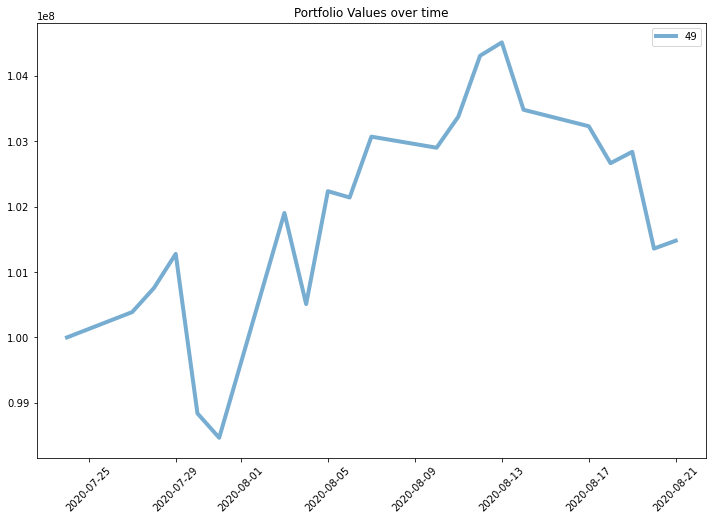

In [17]:
fig, ax = plt.subplots(1,1,figsize=(12,8))
plt.plot(PortfolioTracker[testIDs], alpha=.6, lw=4)
plt.legend(testIDs)
plt.title('Portfolio Values over time')
plt.xticks(rotation=45)
plt.show()